# Check Earth Coordinate quantities: Fermi Altitude and Geodetic Latitude

## To check numbers in JIRA https://jira.slac.stanford.edu/browse/GRINF-76

### Robert Cameron, March 2016

In [1]:
import numpy as np
import astropy.io.fits as fits
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# read in data from an FT2 file

ft2file = "/Users/rc/Documents/GLAST/ISOC/LATmetrics/orbit/rac-Astroserver-00020-ft2-1s.fits"
hdulist = fits.open(ft2file)
ft2data = hdulist[1].data
ft2pos = ft2data.field('SC_POSITION')
ft2lat = ft2data.field('LAT_GEO')
ft2lon = ft2data.field('LON_GEO')
ft2alt = ft2data.field('RAD_GEO')
ft2pos /= 1000
ft2alt /= 1000

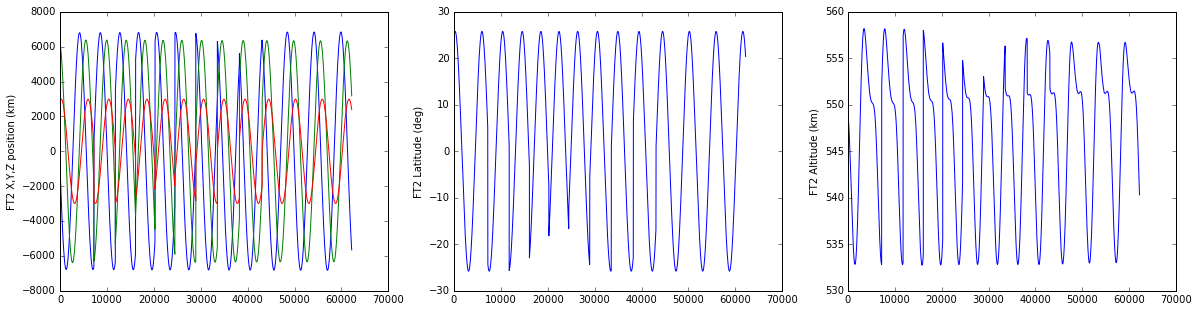

In [3]:
# plot the FT2 position, latitude and altitude data, to check the data look reasonable

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20,5))
ax1.plot(ft2pos)
ax1.set_ylabel('FT2 X,Y,Z position (km)')
ax2.plot(ft2lat)
ax2.set_ylabel('FT2 Latitude (deg)')
ax3.plot(ft2alt)
ax3.set_ylabel('FT2 Altitude (km)')

## Some test calculations of Fermi altitude versus latitude, using first-order approximations (uncorrected CVS code and corrected equation)

In [4]:
# use a simple short array of latitude values

lat = np.linspace(-26.5, 26.5)
sinlat = np.sin(np.radians(lat))
tanlat = np.tan(np.radians(lat))

In [5]:
# altitude case 1 = existing buggy CVS code

f = 1.0/298.25    # gives esqr = f*(2-f) = 0.006694542
a = 6378.145
esqr = 0.00669454
elat2 = (esqr*sinlat)*(esqr*sinlat)
alt1 = a / np.sqrt(1 - elat2)

In [6]:
# altitude case 2 = debugged CVS code

f = 1.0/298.25    # gives esqr = f*(2-f) = 0.006694542
a = 6378.145
esqr = 0.00669454
elat2 = esqr*(sinlat*sinlat)
alt2 = a / np.sqrt(1 - elat2)

In [7]:
# altitude case 3 = improved constants from WG84, with debugged CVS code

f = 1.0/298.257223563
a = 6378.137   
esqr = f*(2.0-f)
elat2 = esqr*(sinlat*sinlat)
alt3 = a / np.sqrt(1 - elat2)

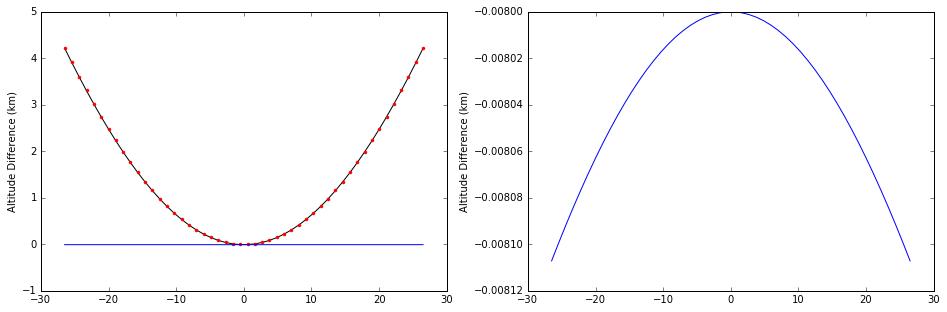

In [8]:
# Plot differences between the 3 altitude test cases: alt1, alt2, alt3
# Note that the correction of the mistake in the CVS code produces an altitude correction of up to 4km.
# Second plot only shows small ~8m difference, reflecting difference between a = 6378.145 and 6378.137 km.

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))

ax1.plot(lat, alt3-alt1, 'k')
ax1.plot(lat, alt2-alt1, 'r.')
ax1.plot(lat, alt3-alt2, 'b')
ax1.set_ylabel('Altitude Difference (km)')

ax2.plot(lat, alt3-alt2, 'b')
ax2.set_ylabel('Altitude Difference (km)')

##  Some test calculations of Fermi latitude, using first-order approximations          (uncorrected CVS code and corrected equation)

In [9]:
# latitude case 1 = existing buggy CVS code

f = 1.0/298.25
fterm = (1.0 - f)*(1.0 - f)
nlat1 = np.arctan(tanlat)/fterm
nlat1 = np.degrees(nlat1)

In [10]:
# latitude case 2 = debugged CVS code

f = 1.0/298.25
fterm = (1.0 - f)*(1.0 - f)
nlat2 = np.arctan(tanlat/fterm)
nlat2 = np.degrees(nlat2)

In [11]:
# latitude case 3 = improved constants from WG84, with debugged CVS code

f = 1.0/298.257223563
fterm = (1.0 - f)*(1.0 - f)
nlat3 = np.arctan(tanlat/fterm)
nlat3 = np.degrees(nlat3)

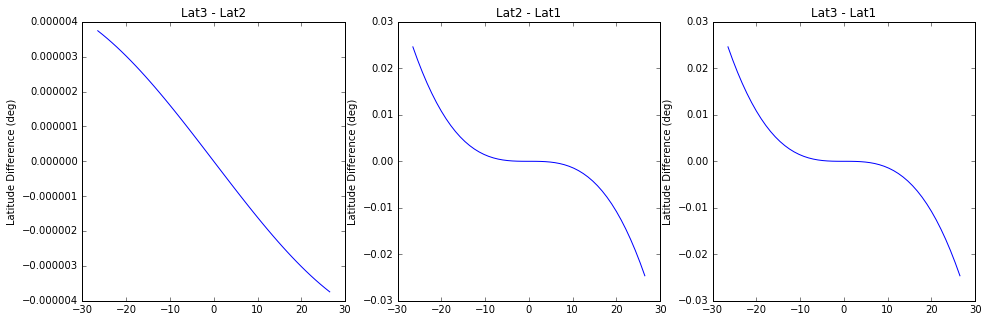

In [12]:
# plot differences of latitude values from the above test cases

fig, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(16,5))

ax1.plot(lat, nlat3-nlat2)
ax1.set_title('Lat3 - Lat2')
ax1.set_ylabel('Latitude Difference (deg)')

ax2.plot(lat, nlat2-nlat1)
ax2.set_title('Lat2 - Lat1')
ax2.set_ylabel('Latitude Difference (deg)')

ax3.plot(lat, nlat3-nlat1)
ax3.set_title('Lat3 - Lat1')
ax3.set_ylabel('Latitude Difference (deg)')

## Calculate 15-step Ferrari's solution of latitude and altitude
### as shown in https://en.wikipedia.org/wiki/Geographic_coordinate_conversion

In [13]:
# using WGS84 numbers

a = 6378.137 
asq = a*a
f = 1.0/298.257223563
fc = 1.0 - f
fcsq = fc * fc
b = a * fc
esq = f * (fc + 1)
e = np.sqrt(esq)
edsq = esq / fcsq
bEsq = asq * esq

In [14]:
print(esq, edsq, b)

0.006694379990141317 0.006739496742276435 6356.752314245179


In [15]:
# Ferrari's 15-step solution calculations of latitude and altitude: lat15 and alt15, 
# for the FT2 spacecraft position data

x = ft2pos.T[0]
y = ft2pos.T[1]
z = ft2pos.T[2]
zsq = z*z
rsq = x*x + y*y
r = np.sqrt(rsq)
f = 54.0 * b*b * zsq
g = rsq + zsq*fcsq - esq*bEsq
c = esq*esq*f*rsq/(g*g*g)
term = 1 + c + np.sqrt(c*(c+2))
s = np.power(term,1.0/3.0)
term = (1 + s + 1.0/s)*g
p = f/(3*term*term)
q = np.sqrt(1 + 2.0*p*esq*esq)
term = asq*(1 + 1.0/q)/2.0 - p*rsq/2.0 - p*zsq*fcsq/(q*(q + 1.0))
r0 = np.sqrt(term) - (p*esq*r/(q + 1))
term = r - r0*esq
u = np.sqrt(zsq + term*term)
v = np.sqrt(term*term + zsq*fcsq)
term = b*b/(v*a)
h15 = u*(1.0 - term) 
z0 = z * term
lat15 = np.arctan((z + z0*edsq)/r)
lat15 = np.degrees(lat15)
alt15 = h15

In [16]:
# undo incorrect calculations in FT2 data and then apply correct calculations,
# to produce corrected first-order FT2 values: cft2lat and cft2alt

ofc = (1.0 - 1.0/298.25)
nfc = (1.0 - 1.0/298.257223563)
ctanft2lat = np.tan(np.radians(ft2lat)*ofc*ofc)/(nfc*nfc)     # prefix 'c' for "corrected" on variable name
cft2lat = np.arctan(ctanft2lat)
ccosft2lat = np.cos(cft2lat)
csinft2lat = np.sin(cft2lat)
cft2alt = r/ccosft2lat - a/np.sqrt(1.0 - esq*csinft2lat*csinft2lat)
cft2lat = np.degrees(cft2lat)

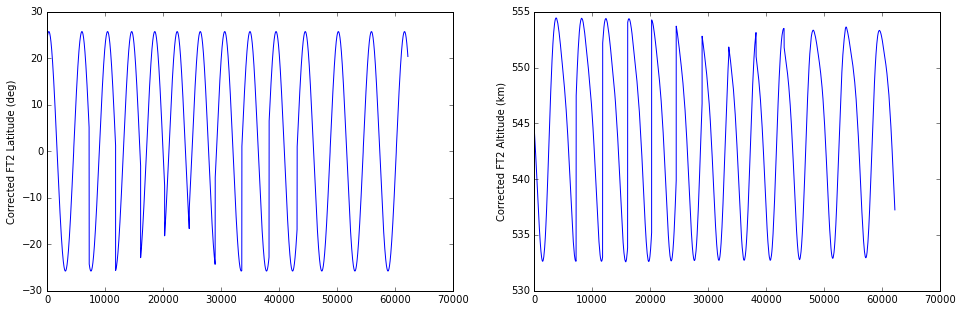

In [17]:
# verify plots of Ferrari latitude and altitude solutions look reasonable

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))

ax1.plot(cft2lat)
ax1.set_ylabel('Corrected FT2 Latitude (deg)')

ax2.plot(cft2alt)
ax2.set_ylabel('Corrected FT2 Altitude (km)')

## We now have 3 versions of latitude and altitude to compare
* the FT2 versions of latitude and altitude : ft2lat, ft2alt
* the first-order corrected FT2 versions : cft2lat, cft2alt
* the Ferrari 15-step versions of latitude and altitude : lat15, alt15

## The green residual curves below demonstrate
* the corrected first-order altitude is within 1 km of the Ferrari altitude
* the corrected first-order latitude is within about 0.01 degrees of the Ferrari latitude

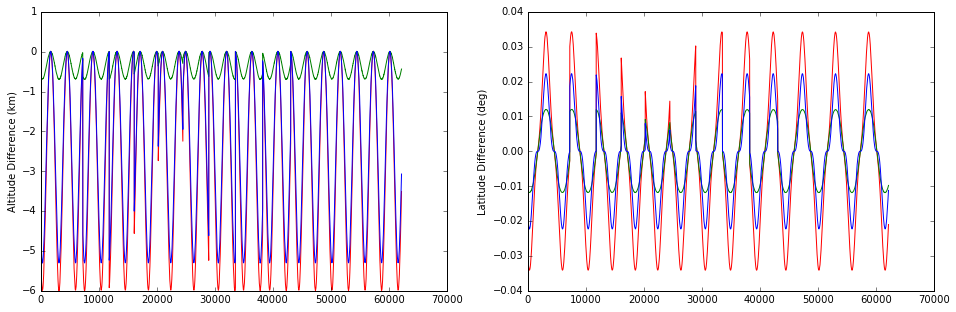

In [18]:
# plot differences between versions of altitude data, and versions of latitude data

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16,5))

ax1.plot(alt15 - ft2alt,'r')
ax1.plot(alt15 - cft2alt, 'g')
ax1.plot(cft2alt - ft2alt, 'b')
ax1.set_ylabel('Altitude Difference (km)')

ax2.plot(lat15 - ft2lat,'r')
ax2.plot(lat15 - cft2lat, 'g')
ax2.plot(cft2lat - ft2lat, 'b')
ax2.set_ylabel('Latitude Difference (deg)')